<a href="https://colab.research.google.com/github/syunar/22-01_Laptops-Prices-Prediction-Analysis/blob/main/laptopmodelpipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prices Prediction

## Problem:
ยอดขายตกลง อาจจะเกิดได้จากหลายสาเหตุ หนึ่งในสาเหตุนั้นก็คือกลไกลการตั้งราคาขายของสินค้า
- เพื่อที่จะเพิ่มประสิทธิภาพในการตั้งราคาขาย
- ไม่รู้ว่าควรจะตั้งราคาเท่าไหร่?
- ขายได้แต่ไม่มีกำไรเพราะตั้งราคาต่ำเกินไป
- ขายไม่ออกเนื่องจากราคาสูงเกินไป
- จะลดราคาลงมาก็จะเท่าทุนอยู่แล้ว เหตุจากต้นทุนสูงจนเกินไป

## Ideate:
การใช้ Machine Learning เพื่อประเมินราคาขาย โดยการใส่ input เป็น ลักษณะของสินค้า เช่น specs, types, grades ของสินค้า และมี output เป็นราคาขาย
- เพื่อประเมินราคาขายจากปัจจัยของสินค้านั้นๆ
- ตรวจสอบดูว่าแต่ละปัจจัยหรือตัวแปรส่งผลต่อราคามากน้อยแค่ไหน เพื่อนำไปเปรียบเทียบกับต้นทุนในแต่ละตัวแปรและตรวจสอบดูว่าเราลงทุนไปกับปัจจัยที่ส่งผลต่อราคาได้มีประสิทธิภาพหรือไม่




สำหรับโปรเจคนี้จะเป็นการทำนายราคาของโน้ตบุ๊ค โดยมีขั้นตอนดังนี้

## Steps/Pipeline:
0. Understand Problems
1. Data Collection
    - ใช้การ WebScraping เว็บไซต์ notebookspec.com เป็นเว็บไซต์เกี่ยวกับคอมพิวเตอร์ โดยจะมีสเปกและราคาของทุกแบรนด์ ซึ่งจำเป็นอย่างมากในการตั้งราคาขาย โดยดูจากราคาตลาดด้วย
2. Data Cleaning
    - Clean column names
    - Handle missing values
    - Feature extraction: Regex
    - Handle duplicated datas
    - Handle outliers
    - Feature Engineering
    
3. Feature Scaling and Split dataset
    - Feature Selection
    - train test split
    - Feature Scaling
4. Train, Test Model (Base line)
5. Improve Model Perfomanace
    - Compare to other models
    - Hyperparameter tuning
6. Feature Importance

## Install and Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from google.colab.data_table import DataTable
DataTable.max_columns = 60
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score


## 1.Data Collection
อ่านไฟล์จากที่เราทำการ webScraping มา

In [ ]:
# create import data function
# 'https://raw.githubusercontent.com/syunar/notebookspec/main/nbprice.csv' -> main table
# 
def load_data():
    df = pd.read_csv('https://raw.githubusercontent.com/syunar/notebookspec/main/nbprice.csv', index_col=0)
    return df

## 2.Data Cleaning

In [ ]:
def clean_data(df):
    clean_df = df.copy()

    # standardize column names
    clean_df.columns = clean_df.columns.str.strip().str.lower()\
                        .str.replace(" ","_")\
                        .str.replace("-","_")\
                        .str.replace("\/","_")\
                        .str.replace(".","")
    
    # clean column 'unnamed:_20 to usbports2
    clean_df.columns = clean_df.columns.str.replace('unnamed:_20','usb_ports2')

    # standardize missing values
    clean_df = clean_df.replace(['NO DATA','N/A', 'null', 'Empty', '?', \
                                 'NaN', '', 'nan'],np.nan)
    
    # clean Thai words
    clean_df = clean_df.replace(['ไม่มี','ไม่','ไม่รองรับ'], 0)
    clean_df = clean_df.replace(['มี','รองรับ'], 1)

    # drop unused columns
    un_cols = ['wireless_lan','body_color','keyboard_type','insurance']
    clean_df.drop(un_cols, axis=1, inplace=True)

    # clean column 'other_detail'
    clean_df['other_detail'] = np.where(clean_df['other_detail'].isna(), 0, 1)

    # clean column 'usb_ports'
    #   create new column to combine those 2 column
    clean_df['total_usb'] = clean_df[['usb_ports', 'usb_ports2']].stack() \
                            .groupby(level=0).agg('_'.join)
    clean_df.drop(['usb_ports2','usb_ports'], axis=1, inplace=True)

    # drop the rows that have missing data more than 3 columns
    clean_df.dropna(thresh=3,inplace=True)

    # drop duplicated datas
    clean_df.drop_duplicates()

    # clean column 'm2_slot'
    #   list of index that have na values
    lsna_m2_slot = clean_df[clean_df['m2_slot'].isna() == 1].index.to_list()
    #   regex to extract number of slots in each m2 type
    clean_df['m2PCIe_slot'] = clean_df.loc[~clean_df.index.isin(lsna_m2_slot)]['m2_slot'] \
                        .str.strip().str.extract(r'(\d{1})[\w\s.]+PCIe').fillna(0)
    clean_df['m2Combo_slot'] = clean_df.loc[~clean_df.index.isin(lsna_m2_slot)]['m2_slot'] \
                        .str.strip().str.extract(r'(\d{1})[\w\s.]+Combo').fillna(0)
    clean_df['m2SATA_slot'] = clean_df.loc[~clean_df.index.isin(lsna_m2_slot)]['m2_slot'] \
                        .str.strip().str.extract(r'(\d{1})[\w\s.]+SATA').fillna(0)
    #   mode imputation on na values
    clean_df['m2PCIe_slot'].fillna(clean_df[['m2PCIe_slot',
                                             'm2Combo_slot',
                                             'm2SATA_slot']].value_counts().idxmax()[0],inplace=True)
    clean_df['m2Combo_slot'].fillna(clean_df[['m2PCIe_slot',
                                              'm2Combo_slot',
                                              'm2SATA_slot']].value_counts().idxmax()[1],inplace=True)
    clean_df['m2SATA_slot'].fillna(clean_df[['m2PCIe_slot',
                                             'm2Combo_slot',
                                             'm2SATA_slot']].value_counts().idxmax()[2],inplace=True)
    clean_df.drop(['m2_slot'], axis=1, inplace=True)

    # clean column 'panel_type'
    clean_df['panel_type'].fillna(clean_df['panel_type'].value_counts().idxmax(), inplace=True)

    # clean column 'warranty'
    clean_df['warranty'] = clean_df['warranty'].str.strip().str.extract(r'(\d+)\s?[yY]')
    #   mode imputation
    clean_df['warranty'].fillna(clean_df['warranty'].value_counts().idxmax(), inplace=True)

    # clean column 'battery_type'
    #   this column contains different types of data in each row
    #   so I decided to drop this column.
    clean_df.drop(['battery_type'], axis=1, inplace=True)

    # clean column 'numpad'
    #   drop the rows that have na
    clean_df.dropna(subset=['numpad'],inplace=True)

    # clean column 'web_camera'
    #   list of index that contain group for each group
    lsi_high = clean_df['web_camera'][clean_df['web_camera'].str.contains(r'5.0|5M')==1].index
    lsi_belowhd = clean_df['web_camera'][clean_df['web_camera'].str.contains('640|0.3|vga',case=False)==1].index
    lsi_hd = clean_df['web_camera'][clean_df['web_camera'].str.contains(r'[^FBelow Above F]\s?HD|720|^HD')==1].index
    lsi_none = clean_df['web_camera'][clean_df['web_camera'].str.contains(r'\-|None|No')==1].index
    lsi_fhd = clean_df['web_camera'][clean_df['web_camera'].str.contains(r'^FHD|1080|Full HD Camera|^Full|^IR')==1].index
    lsi_mid = clean_df['web_camera'][clean_df['web_camera'].str.contains(r'0.9|1|1.0|1.3|2')==1].index
    #   replace
    clean_df.loc[lsi_high, ['web_camera']] = clean_df.loc[lsi_high]['web_camera'].str.replace('.+','Above FHD')
    clean_df.loc[lsi_belowhd, ['web_camera']] = clean_df.loc[lsi_belowhd]['web_camera'].str.replace('.+','Below HD')
    clean_df.loc[lsi_hd, ['web_camera']] = clean_df.loc[lsi_hd]['web_camera'].str.replace('.+','HD')
    clean_df.loc[lsi_none, ['web_camera']] = clean_df.loc[lsi_none]['web_camera'].str.replace('.+','none')
    clean_df.loc[lsi_fhd, ['web_camera']] = clean_df.loc[lsi_fhd]['web_camera'].str.replace('.+','FHD')
    clean_df.loc[lsi_mid, ['web_camera']] = clean_df.loc[lsi_mid]['web_camera'].str.replace('.+','1-2MP')
    #   mode imputation
    clean_df['web_camera'].fillna(clean_df['web_camera'].value_counts().idxmax(), inplace=True)

    # clean column 'prices'
    clean_df['prices'] = clean_df['prices'].str.replace(',','')\
                          .str.replace('x','0')

    # clean column 'cpu'
    clean_df['cpu'] = clean_df['cpu'].str.split('(').str[0].str.strip()

    # clean column 'gpu'
    clean_df['gpu'] = clean_df['gpu'].str.split('(').str[0].str.strip()

    # clean column 'size'
    clean_df['size'] = clean_df['size'].str.split(" ").str[0]

    # clean column 'resolution'
    df_res = clean_df['resolution'].str.lower().str.replace(' ','')\
                .str.extract(r'(\d+)[xX]+(\d+)').astype('int')
    clean_df['resolution'] = df_res[0] * df_res[1]

    # clean column 'refresh_rate'
    clean_df['refresh_rate'] = clean_df['refresh_rate'].str.extract(r'(\d+)')
    #   mode imputation
    clean_df['refresh_rate'].fillna(clean_df['refresh_rate'].value_counts().idxmax(), inplace=True)

    # clean column 'memory_size'
    #   regex extract #gb and memory type
    df_mem = clean_df['memory_size'].str.extract(r'(\d+) GB ([\w]+)')\
            .rename(columns={0: 'mem_size', 1:'mem_type'})
    #   add new columns
    clean_df['mem_size'] = df_mem['mem_size']
    clean_df['mem_type'] = df_mem['mem_type']
    #   add new column if its onboard = 1, ifnot = 0
    clean_df['mem_onboard'] = np.where(clean_df['memory_size'].str.contains('board',case=False),1,0)
    clean_df.drop(['memory_size'], axis=1, inplace=True)

    # clean column 'memory_slot'
    clean_df['memory_slot'] = clean_df['memory_slot'].str.strip().str.replace(' Slots','')

    # clean column 'hard_disk_drive'
    clean_df['hard_disk_drive'] = np.where(clean_df['hard_disk_drive'].str.contains(r'none',case=False),0,1)

    # clean column 'solid_state_drive'
    #   regex and extract to 2 cols : ssd_size and ssd_type
    df_ssd = clean_df['solid_state_drive'].str.strip()\
                .str.replace(' ','')\
                .str.extract(r'(?P<ssd_size>^[\d.]+)(?P<ssd_unit>[\w]{2})')\
                .fillna(0)
    #   if it is TB so we have to mutiple by 1000 to convert to GB
    df_ssd['ssd_size'] = df_ssd['ssd_size'].astype('float')
    cond = df_ssd['ssd_unit'] == 'TB'
    df_ssd.loc[cond,['ssd_size']] = df_ssd.loc[cond,['ssd_size']] * 1000
    df_ssd['ssd_size'] = df_ssd['ssd_size'].astype('int')
    clean_df = clean_df.join(df_ssd['ssd_size'])
    clean_df.drop(['solid_state_drive'], axis=1, inplace=True)

    # clean column 'hdmi'
    clean_df['hdmi'] = clean_df['hdmi'].str.extract(r'(\d)+').fillna(0)

    # clean column 'displayport'
    clean_df['displayport'] = clean_df['displayport'].str.extract(r'(\d)+').fillna(0)

    # clean column os_bundle
    #   list of index that are windows11 and windows10 (every version)
    lsi_w11 = clean_df[clean_df['os_bundle'].str.contains('windows 11',case=False) == 1].index
    lsi_w10 = clean_df[clean_df['os_bundle'].str.contains('windows 10',case=False) == 1].index
    #   group to windows 11 and windows 10
    clean_df.loc[lsi_w11,['os_bundle']] = clean_df.loc[lsi_w11]['os_bundle'].str.replace(r'.+','Windows 11')
    clean_df.loc[lsi_w10,['os_bundle']] = clean_df.loc[lsi_w10]['os_bundle'].str.replace(r'.+','Windows 10')

    # clean column 'body_material'
    rep = {'Plastic':'Plastic',
            'Aluminium + Plastic':'Aluminium + Plastic',
            'Aluminum':'Aluminium',
            'Aluminum + Magnesium':'Aluminium Alloy',
            'Aluminium Alloy':'Aluminium Alloy',
            'Plastic - Covered by Alu':'Aluminium + Plastic',
            'Metallic':'Aluminium',
            'Mg Alloy':'Magnesium Alloy',
            'Magnesium Alloy':'Magnesium Alloy',
            'Magnesium Alloy + Plastic':'Magnesium Alloy',
            'Anodized aluminum':'Aluminium',
            'Carbon + Aluminum':'Aluminium Alloy',
            'Carbon Fiber + Magnesium':'Carbon Fiber',
            'Carbon Fiber':'Carbon Fiber'}
    clean_df['body_material'] = clean_df['body_material'].map(rep)

    # clean column 'weight'
    clean_df['weight'] = clean_df['weight'].str.split(' ').str[0]

    # clean column 'usb'
    clean_df['usbtype_A'] = clean_df['total_usb'].str.extract(r'(\d)+x\s?USB\s?\d\.\d\s?Type\s?[aA]|(\d+).+\d{1}\.[\d{1}][^\s]').fillna(0).astype(int).sum(axis=1)
    clean_df['usbtype_C'] = clean_df['total_usb'].str.extract(r'(\d)+x\s?USB\s?\d\.\d\s?Type\s?[cC]').fillna(0)
    clean_df.drop(['total_usb'], axis=1, inplace=True)

    # clean column 'ethernet_lan'
    clean_df['ethernet_lan'].astype('int')

    # clean column 'keyboard_backlit'
    clean_df['keyboard_backlit'] = clean_df['keyboard_backlit'].astype(int)

    #   convert numeric data type
    nums = ['prices','size', 'resolution', 'refresh_rate','memory_slot', 'hdmi',
            'weight', 'warranty', 'm2PCIe_slot', 'm2Combo_slot', 'm2SATA_slot',
            'mem_size', 'ssd_size', 'usbtype_A', 'usbtype_C',
            'displayport',  'touch_screen', 'hard_disk_drive', 'd_sub_vga',
            'thunderbolt','ethernet_lan', 'optical_drive','fingerprint',
            'keyboard_backlit', 'numpad', 'other_detail', 'mem_onboard']
    for num in nums:
        clean_df[num] = clean_df[num].apply(pd.to_numeric, errors='coerce')


    return clean_df


## 3.Feature Engineering, Feature Scaling, and Split dataset

In [ ]:
def create_dataset_standard(clean_df, scalertype, random_state=42):
    # Feature Engineering
        #   convert norminal category data type
    cats = ['panel_type', 'os_bundle','body_material','mem_type']
    clean_df = pd.get_dummies(clean_df, columns=cats)

    #   convert ordinal category data type
    ord_cats = ['cpu', 'gpu', 'bluetooth', 'web_camera']
    #       read data cpu and gpu ranking
    df_cpu = pd.read_csv('https://raw.githubusercontent.com/syunar/22-01_Laptops-Prices-Prediction-Analysis/main/cpu_rank.csv', index_col=0)
    df_gpu = pd.read_csv('https://raw.githubusercontent.com/syunar/22-01_Laptops-Prices-Prediction-Analysis/main/gpu_rank.csv', index_col=0)

    df_cpu.drop_duplicates(subset=['cpu_name'], inplace=True)
    df_gpu.drop_duplicates(subset=['gpu_name'], inplace=True)

    clean_df.drop(clean_df[~clean_df['cpu'].isin(df_cpu['cpu_name'])].index, inplace=True)
    clean_df.drop(clean_df[~clean_df['gpu'].isin(df_gpu['gpu_name'])].index, inplace=True)

    #      convert to ordinal cat on cpu
    cpu_cat = df_cpu['cpu_name'].to_list()
    cpu_cat.reverse()
    cpu_train = [i for i in cpu_cat if i in clean_df['cpu'].unique()]
    enc_cpu = OrdinalEncoder(categories=[cpu_train])
    enc_cpu.fit(clean_df[['cpu']])
    clean_df[['cpu_enc']] = enc_cpu.transform(clean_df[['cpu']])

    #      convert to ordinal cat on gpu
    gpu_cat = df_gpu['gpu_name'].to_list()
    gpu_cat.reverse()
    gpu_train = [i for i in gpu_cat if i in clean_df['gpu'].unique()]
    enc_gpu = OrdinalEncoder(categories=[gpu_train])
    enc_gpu.fit(clean_df[['gpu']])
    clean_df[['gpu_enc']] = enc_gpu.transform(clean_df[['gpu']])

    #       convert to ordinal cat on bluetooth
    bt_cat = ['Bluetooth 4.0','Bluetooth 4.1','Bluetooth 4.2','Bluetooth 5.0','Bluetooth 5.1','Bluetooth 5.2']
    enc_bt = OrdinalEncoder(categories=[bt_cat])
    enc_bt.fit(clean_df[['bluetooth']])
    clean_df[['bluetooth_enc']] = enc_bt.transform(clean_df[['bluetooth']])

    #       convert to ordinal cat on web_camera
    wcam_cat = ['none','Below HD','HD','1-2MP','FHD','Above FHD']
    enc_wc = OrdinalEncoder(categories=[wcam_cat])
    enc_wc.fit(clean_df[['web_camera']])
    clean_df[['web_camera_enc']] = enc_wc.transform(clean_df[['web_camera']])

    clean_df.drop(ord_cats,axis=1,inplace=True)


    # train test split
    y = clean_df['prices'].values
    X = clean_df.drop(['names', 'urls', 'model', 'model_year', 'brand', 'prices'], axis=1).copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    print(f'Data for Modeling: features={X_train.shape}, target={y_train.shape}')
    print(f'Unseen Data For Predictions: features={X_test.shape}, target={y_test.shape}')

    # Feature Scaling
    scaler = scalertype()
    #   Scale only numerical data
    nums = ['size', 'resolution', 'refresh_rate','memory_slot', 'hdmi',
        'weight', 'warranty', 'm2PCIe_slot', 'm2Combo_slot', 'm2SATA_slot',
        'mem_size', 'ssd_size', 'usbtype_A', 'usbtype_C',
        'displayport',  'touch_screen', 'hard_disk_drive', 'd_sub_vga',
        'thunderbolt','ethernet_lan', 'optical_drive','fingerprint',
        'keyboard_backlit', 'numpad', 'other_detail', 'mem_onboard']
    scaler = scaler.fit(X_train[nums])     
    X_train[nums] = scaler.transform(X_train[nums])
    X_test[nums] = scaler.transform(X_test[nums])


    return X_train, X_test, y_train, y_test, enc_cpu, enc_gpu, enc_bt, enc_wc, scaler, gpu_train, cpu_train

## 4.Create Model

In [ ]:
# create function train test model
def model(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    y_ptrain = model.predict(X_train)
    y_ptest = model.predict(X_test)
    print(f'model score = R2_train:{r2_score(y_train,y_ptrain)}, RMSE_train:{mse(y_train,y_ptrain,squared=False)}')
    print(f'model score = R2_test:{r2_score(y_test,y_ptest)}, RMSE_test:{mse(y_test,y_ptest,squared=False)}')

    r2 = r2_score(y_test,y_ptest)
    rsme = mse(y_test,y_ptest,squared=False)

    #   plot r2
    score = pd.DataFrame({'y_test':y_test,
                'y_ptest':y_ptest})
    sns.set_style('ticks')
    ax = sns.regplot(x='y_test',y='y_ptest', data=score, fit_reg=True,
                scatter_kws={'alpha': 0.3}, line_kws={"color": "red"});

    plt.text(0.05, 0.95, s=f"r^2={r2:.2f}, rsme={rsme:.2f}", ha="left", va="top", transform=ax.transAxes)
    plt.show()
    return

### Base line model

Data for Modeling: features=(1758, 57), target=(1758,)
Unseen Data For Predictions: features=(587, 57), target=(587,)
model score = R2_train:0.8780131593131003, RMSE_train:8172.742377201934
model score = R2_test:0.8750793794024465, RMSE_test:8383.272337057992


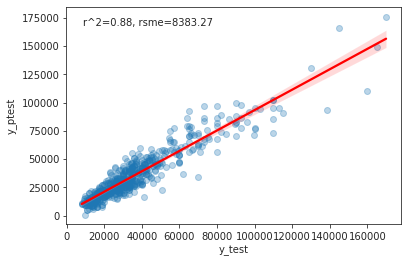

In [ ]:
df = load_data()
clean_df = clean_data(df)
X_train, X_test, y_train, y_test, enc_cpu, enc_gpu, enc_bt, enc_wc, scaler, gpu_train, cpu_train = create_dataset_standard(clean_df, MinMaxScaler)
model(LinearRegression(), X_train, X_test, y_train, y_test)

หลังจาก train และ test model พบว่า RMSE_test=8383.27 โดย r_square=0.88 ในขั้นตอนต่อไปเราจะลองใช้ model อื่นๆและทำการ hyperparameter tuning เพื่อลดค่า RSME และเพิ่มค่า r_square

### Improve Model Perfomance

In [ ]:
def modeltuning(X_train, X_test, y_train, y_test):
    # create model pipeline
    pipelines = {
        'rf': make_pipeline(RandomForestRegressor(random_state=42)),
        'gb': make_pipeline(GradientBoostingRegressor(random_state=42)),
        'ridge': make_pipeline(Ridge(random_state=42)),
        'lasso': make_pipeline(Lasso(random_state=42)),
        'enet': make_pipeline(ElasticNet(random_state=42))
    }

    #   hyperparameter
    hypergrid = {
    'rf': {
        'randomforestregressor__max_depth': [10, 20]
    },
    'gb': {
        'gradientboostingregressor__alpha': [0.001, 0.01, 0.1]
    },
    'ridge': {
        'ridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'lasso': {
        'lasso__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'enet': {
        'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    }}

    #   train and tuning model
    #       fit_models is collect best model from hyperparameter tuning
    fit_models = {}
    for algo, pipeline in pipelines.items():
        model = GridSearchCV(pipeline, hypergrid[algo], cv=10, n_jobs=-1, scoring='neg_root_mean_squared_error')
        try:
            print(f'Starting training for {algo}.')
            model.fit(X_train, y_train)
            fit_models[algo] = model.best_estimator_._final_estimator
            print(f'{algo} has been successfully fit.')
        except NotFittedError as e:
            print(repr(e))

    #   compare score RSME each model
    score = []
    for algo,model in fit_models.items():  
        p_test = model.predict(X_test)
        r2 = r2_score(y_test,p_test)
        rsme = mse(y_test,p_test,squared=False)

        keys = ['algo', 'r2', 'rsme']
        values = [algo, r2, rsme]
        temp = {}
        temp.update({k:v for k,v in zip(keys,values)})
        score.append(temp)

    score_df = pd.DataFrame(score).sort_values(by='rsme')
    print(score_df)
    best_model = fit_models[score_df['algo'][0]]
    best_rsme = score_df['rsme'][0]

    return best_model, best_rsme

## 5.Feature Importance

In [ ]:
def feature_imp(model,X_train):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    fig = plt.figure(figsize=(10, 10))
    plt.barh(pos, feature_importance[sorted_idx], align="center")
    plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
    plt.title("Feature Importance")
    fig.tight_layout()
    plt.show()

## 6.Data Pipeline

In [ ]:
def modelpipeline():
    # load data
    df = load_data()

    # clean data
    clean_df = clean_data(df)

    # encoing, split data, scaling
    X_train, X_test, y_train, y_test, enc_cpu, enc_gpu, enc_bt, enc_wc, scaler, gpu_train, cpu_train = create_dataset_standard(clean_df, MinMaxScaler)

    # tuning model
    best_model, best_rsme = modeltuning(X_train, X_test, y_train, y_test)
    print(best_model)

    # plot r^2
    model(best_model, X_train, X_test, y_train, y_test)

    # plot feature importance
    feature_imp(best_model, X_train)

    # create pipeline
    pipeline = {'model': best_model,
                'enc_cpu': enc_cpu,
                'enc_gpu': enc_gpu,
                'enc_bt': enc_bt,
                'enc_wc': enc_wc,
                'scaler': scaler,
                'gpu': gpu_train,
                'cpu': cpu_train,
                'col': X_train.columns}

    return pipeline


Data for Modeling: features=(1758, 57), target=(1758,)
Unseen Data For Predictions: features=(587, 57), target=(587,)
Starting training for rf.
rf has been successfully fit.
Starting training for gb.
gb has been successfully fit.
Starting training for ridge.
ridge has been successfully fit.
Starting training for lasso.
lasso has been successfully fit.
Starting training for enet.
enet has been successfully fit.
    algo        r2         rsme
0     rf  0.930327  6260.778461
1     gb  0.926832  6415.913513
4   enet  0.876012  8351.922998
3  lasso  0.875377  8373.277703
2  ridge  0.875236  8378.030601
RandomForestRegressor(max_depth=20, random_state=42)
model score = R2_train:0.9881134393843999, RMSE_train:2551.1701338151292
model score = R2_test:0.9303271370889112, RMSE_test:6260.778460523787


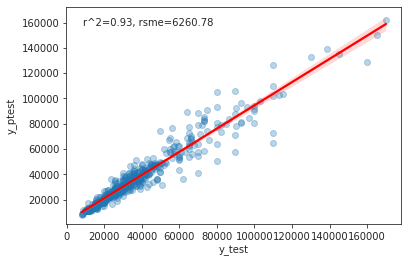

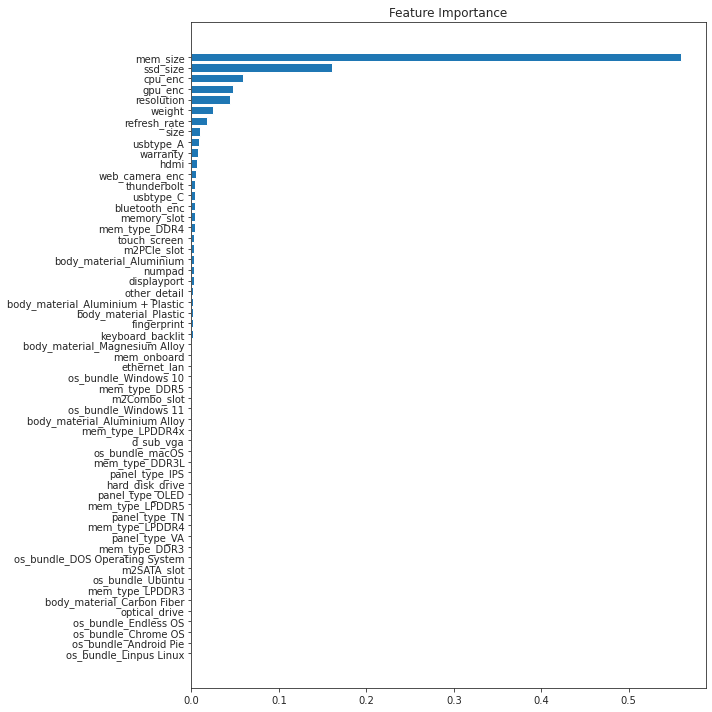

In [ ]:
pipeline = modelpipeline()

## Save Model

In [ ]:
import pickle

In [ ]:
with open('model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)